In [1]:
import glob
import numpy as np
import os.path as path
from scipy import misc

In [3]:
IMAGE_PATH = ''
file_paths = glob.glob(path.join('C:\\Users\\VINOTH S\\ML\\Cloud Image\\planesnet', '*.png'))

In [5]:
images = [misc.imread(path) for path in file_paths]
images = np.asarray(images)

C:\Users\VINOTH S\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [6]:
image_size = np.asarray([images.shape[1], images.shape[2], images.shape[3]])
print(image_size)

[20 20  3]


In [7]:
images = images / 255

In [8]:
n_images = images.shape[0]
labels = np.zeros(n_images)
for i in range(n_images):
    filename = path.basename(file_paths[i])[0]
    labels[i] = int(filename[0])

In [9]:
TRAIN_TEST_SPLIT = 0.9


In [10]:
split_index = int(TRAIN_TEST_SPLIT * n_images)
shuffled_indices = np.random.permutation(n_images)
train_indices = shuffled_indices[0:split_index]
test_indices = shuffled_indices[split_index:]

In [11]:
x_train = images[train_indices, :, :, :]
y_train = labels[train_indices]
x_test = images[test_indices, :, :, :]
y_test = labels[test_indices]

In [12]:
import matplotlib.pyplot as plt

In [13]:
def visualize_data(positive_images, negative_images):
    # INPUTS
    # positive_images - Images where the label = 1 (True)
    # negative_images - Images where the label = 0 (False)

    figure = plt.figure()
    count = 0
    for i in range(positive_images.shape[0]):
        count += 1
        figure.add_subplot(2, positive_images.shape[0], count)
        plt.imshow(positive_images[i, :, :])
        plt.axis('off')
        plt.title("1")

        figure.add_subplot(1, negative_images.shape[0], count)
        plt.imshow(negative_images[i, :, :])
        plt.axis('off')
        plt.title("0")
    plt.show()

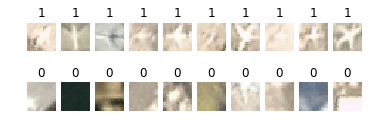

In [14]:
# Number of positive and negative examples to show
N_TO_VISUALIZE = 10

# Select the first N positive examples
positive_example_indices = (y_train == 1)
positive_examples = x_train[positive_example_indices, :, :]
positive_examples = positive_examples[0:N_TO_VISUALIZE, :, :]

# Select the first N negative examples
negative_example_indices = (y_train == 0)
negative_examples = x_train[negative_example_indices, :, :]
negative_examples = negative_examples[0:N_TO_VISUALIZE, :, :]

# Call the visualization function
visualize_data(positive_examples, negative_examples)

In [15]:
# Imports
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import accuracy_score, f1_score
from datetime import datetime

Using TensorFlow backend.


In [16]:
N_LAYERS = 4

In [17]:
def cnn(size, n_layers):
    # INPUTS
    # size     - size of the input images
    # n_layers - number of layers
    # OUTPUTS
    # model    - compiled CNN

    # Define hyperparamters
    MIN_NEURONS = 20
    MAX_NEURONS = 120
    KERNEL = (3, 3)

    # Determine the # of neurons in each convolutional layer
    steps = np.floor(MAX_NEURONS / (n_layers + 1))
    nuerons = np.arange(MIN_NEURONS, MAX_NEURONS, steps)
    nuerons = nuerons.astype(np.int32)

    # Define a model
    model = Sequential()

    # Add convolutional layers
    for i in range(0, n_layers):
        if i == 0:
            shape = (size[0], size[1], size[2])
            model.add(Conv2D(nuerons[i], KERNEL, input_shape=shape))
        else:
            model.add(Conv2D(nuerons[i], KERNEL))

        model.add(Activation('relu'))

    # Add max pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(MAX_NEURONS))
    model.add(Activation('relu'))

    # Add output layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Print a summary of the model
    model.summary()

    return model

In [18]:
model = cnn(size=image_size, n_layers=N_LAYERS)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 18, 18, 20)        560       
_________________________________________________________________
activation_1 (Activation)    (None, 18, 18, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 44)        7964      
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 44)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 68)        26996     
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 68)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 92)        56396     
__________

In [19]:
EPOCHS = 150
BATCH_SIZE = 200

In [20]:
PATIENCE = 10
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=PATIENCE, verbose=0, mode='auto')

In [21]:
# TensorBoard callback
LOG_DIRECTORY_ROOT = ''
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
log_dir = "{}/run-{}/".format(LOG_DIRECTORY_ROOT, now)
tensorboard = TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)

In [22]:
tensorboard --logdir LOG_DIRECTORY_ROOT

SyntaxError: invalid syntax (<ipython-input-22-98927552c2ee>, line 1)

In [23]:
callbacks = [early_stopping, tensorboard]

In [24]:
model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=0)

In [25]:
test_predictions = model.predict(x_test)
test_predictions = np.round(test_predictions)

In [26]:
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy: " + str(accuracy))

Accuracy: 0.986875


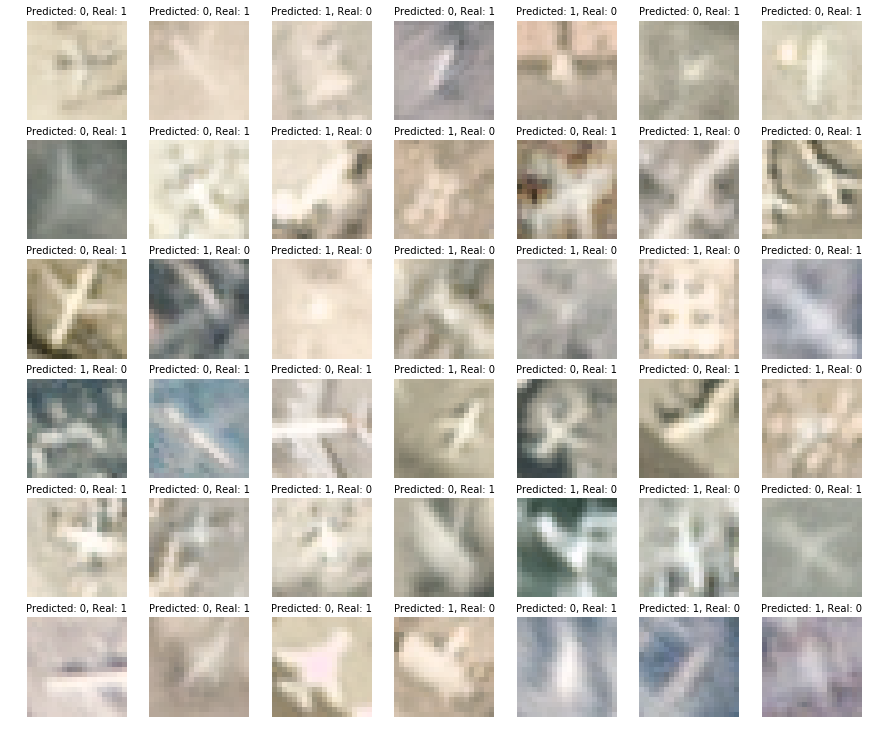

In [31]:
import matplotlib.pyplot as plt
def visualize_incorrect_labels(x_data, y_real, y_predicted):
    # INPUTS
    # x_data      - images
    # y_data      - ground truth labels
    # y_predicted - predicted label
    count = 0
    figure = plt.figure(figsize=[15,15])
    incorrect_label_indices = (y_real != y_predicted)
    y_real = y_real[incorrect_label_indices]
    y_predicted = y_predicted[incorrect_label_indices]
    x_data = x_data[incorrect_label_indices, :, :, :]

    maximum_square = np.ceil(np.sqrt(x_data.shape[0]))

    for i in range(x_data.shape[0]):
        count += 1
        figure.add_subplot(maximum_square, maximum_square, count)
        plt.imshow(x_data[i, :, :, :])
        plt.axis('off')
        plt.title("Predicted: " + str(int(y_predicted[i])) + ", Real: " + str(int(y_real[i])), fontsize=10)

    plt.show()

visualize_incorrect_labels(x_test, y_test, np.asarray(test_predictions).ravel())

In [33]:
test_predictions

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

In [34]:
y_test

array([0., 0., 0., ..., 0., 0., 1.])